In [21]:
import src.service.get_data as av
import src.model.SplitData as sd
import src.model.WindowGenerator as wg
import src.model.Baseline as bl
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import src.model.ComplieFit as cf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [22]:
API_KEY = "trail"
alpha_vantage = av.AlphaVantageAPI(API_KEY)
df = alpha_vantage.get_weekly_stock_prices("AAPL")

2025-03-05 06:16:25,956 - INFO - Calling URL: https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol=AAPL&apikey=trail&outputsize=full


In [23]:
split_data = sd.SplitData(df)

In [24]:
window = wg.WindowGenerator(input_width=30, label_width=5, shift=6, split_data=split_data, label_columns=['close'])
window

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [31 32 33 34 35]
Label column name(s): ['close']

In [25]:
# Stack three slices, the length of the total window.
example_window = tf.stack([
            np.array(split_data.train_df[:window.total_window_size]),
            np.array(split_data.train_df[100:100+window.total_window_size]),
            np.array(split_data.train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 36, 7)
Inputs shape: (3, 30, 7)
Labels shape: (3, 5, 1)


In [26]:
#window.example = example_inputs, example_labels

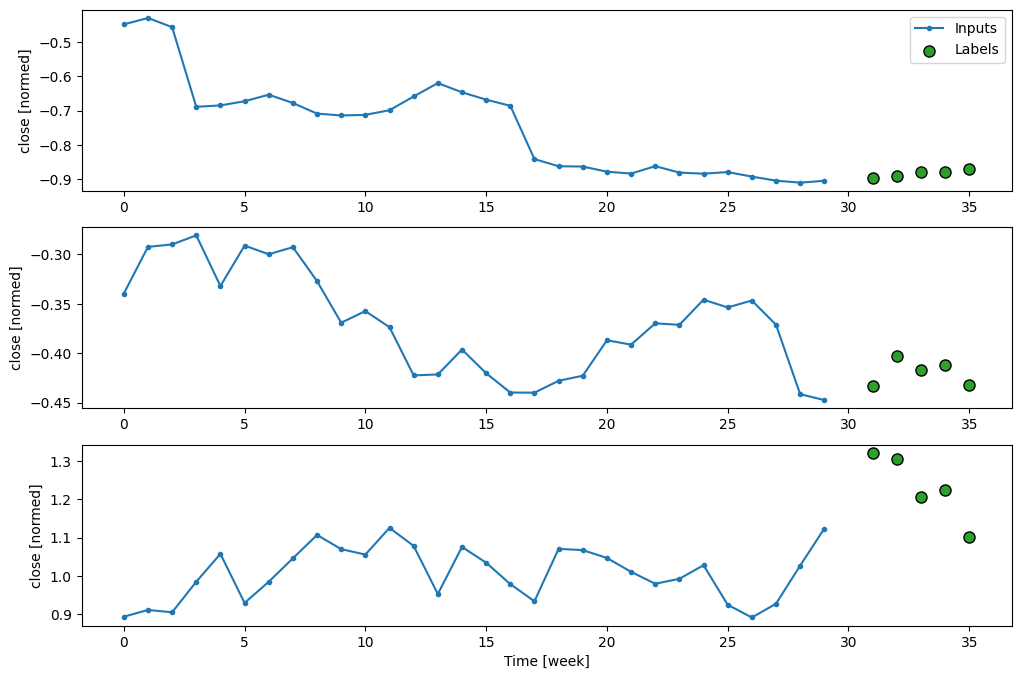

In [27]:
window.plot()

In [28]:
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 7)
Labels shape (batch, time, features): (32, 5, 1)


In [29]:
single_step_window = wg.WindowGenerator(
    input_width=1, label_width=1, shift=1,split_data=split_data,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [30]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


2025-03-05 06:16:29.142506: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
"""class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]"""

'class Baseline(tf.keras.Model):\n  def __init__(self, label_index=None):\n    super().__init__()\n    self.label_index = label_index\n\n  def call(self, inputs):\n    if self.label_index is None:\n      return inputs\n    result = inputs[:, :, self.label_index]\n    return result[:, :, tf.newaxis]'

In [32]:
baseline = bl.Baseline(label_index=single_step_window.column_indices['close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331 - mean_absolute_error: 0.0485  


In [33]:
wide_window = wg.WindowGenerator(
    input_width=24, label_width=24, shift=1, split_data = split_data,
    label_columns=['close'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

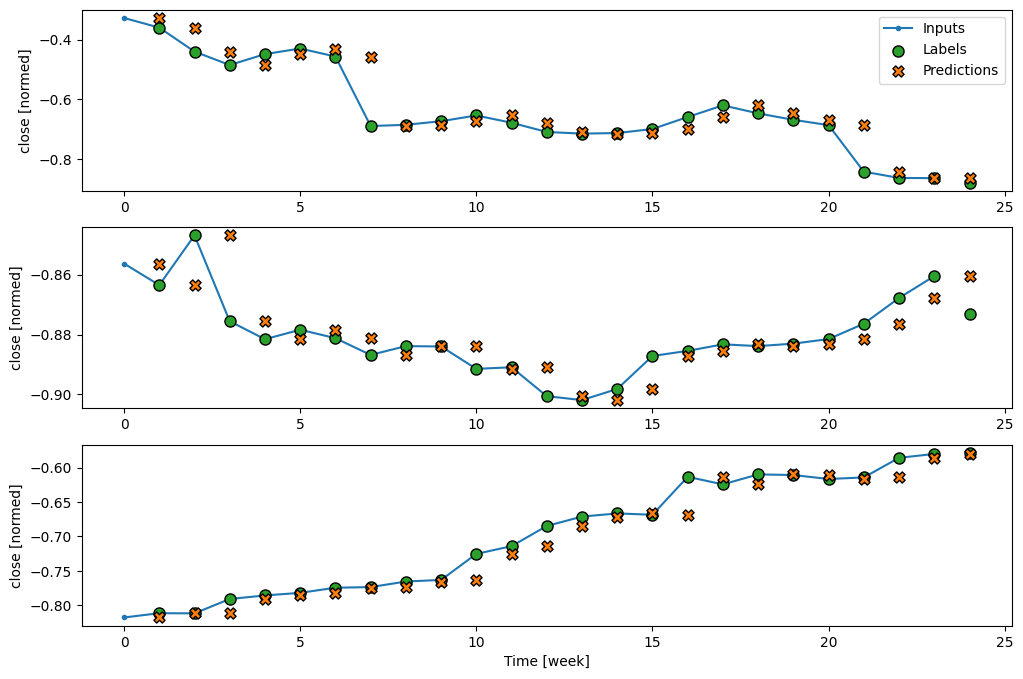

In [34]:
wide_window.plot(baseline)

In [35]:
linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
    ])
history = cf.compile_and_fit(linear, single_step_window)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3561 - mean_absolute_error: 1.6110 - val_loss: 57.3025 - val_mean_absolute_error: 6.2394
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8145 - mean_absolute_error: 1.5084 - val_loss: 56.8396 - val_mean_absolute_error: 6.2358
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5164 - mean_absolute_error: 1.4472 - val_loss: 55.7726 - val_mean_absolute_error: 6.1950
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0397 - mean_absolute_error: 1.3445 - val_loss: 53.9741 - val_mean_absolute_error: 6.1089
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8110 - mean_absolute_error: 1.2834 - val_loss: 52.5424 - val_mean_absolute_error: 6.0430
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5714 - mean_absolute_error: 1.2247 - val_loss: 50.7954 - val_mean_absolute_error: 5.9554
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1469 - mean_absolute_error: 1.1189 - val_loss:

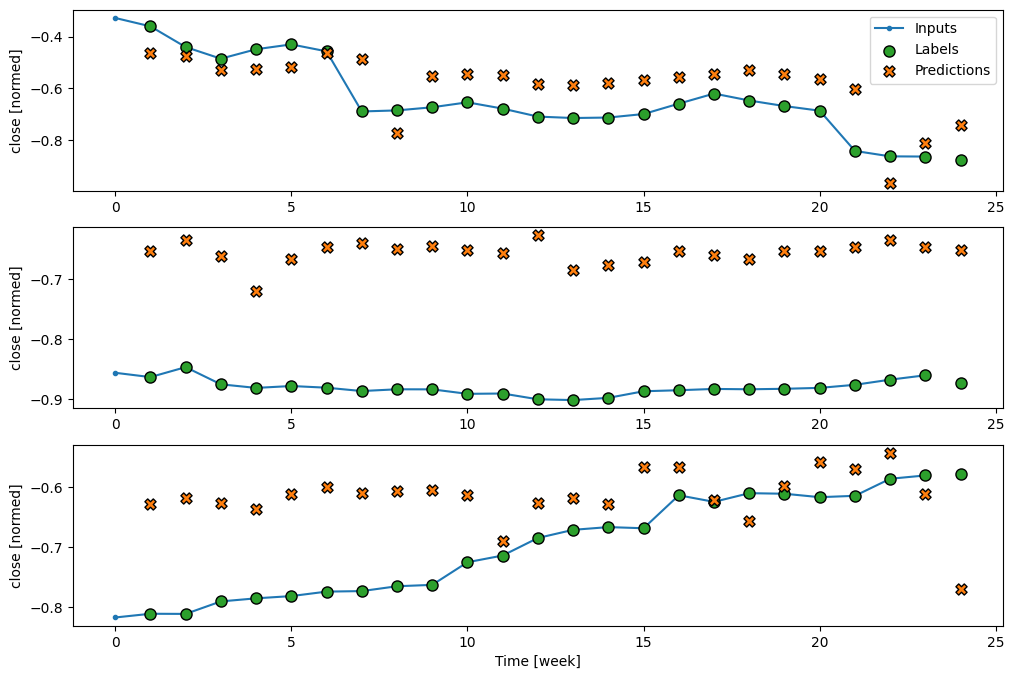

In [36]:
wide_window.plot(linear)

In [37]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = cf.compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3714 - mean_absolute_error: 0.4138 - val_loss: 0.0625 - val_mean_absolute_error: 0.1661
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - mean_absolute_error: 0.0724 - val_loss: 0.0971 - val_mean_absolute_error: 0.2204
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0511 - val_loss: 0.0461 - val_mean_absolute_error: 0.1424
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0461 - val_loss: 0.1724 - val_mean_absolute_error: 0.3151
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0469 - val_loss: 0.0556 - val_mean_absolute_error: 0.1652
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 0.0505 - mean_absolute_error: 0.1649


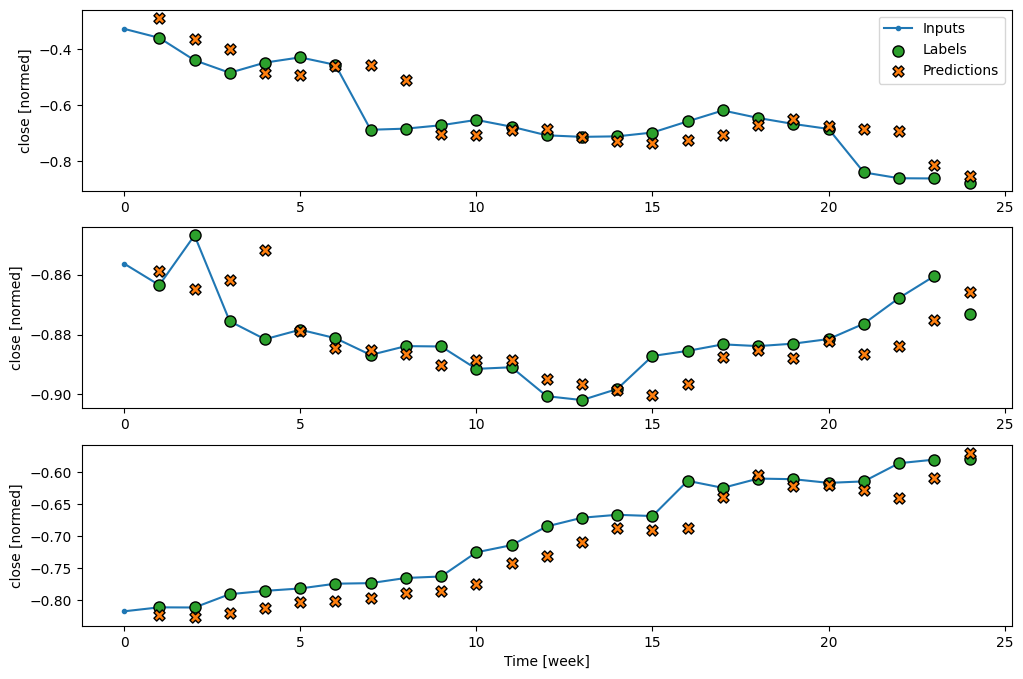

In [38]:
wide_window.plot(dense)

In [39]:
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)
val_performance['Dense']

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0556 - mean_absolute_error: 0.1657 


{'loss': 0.05564647912979126, 'mean_absolute_error': 0.16520656645298004}

In [42]:
CONV_WIDTH = 3
conv_window = wg.WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    split_data = split_data,
    label_columns=['close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['close']

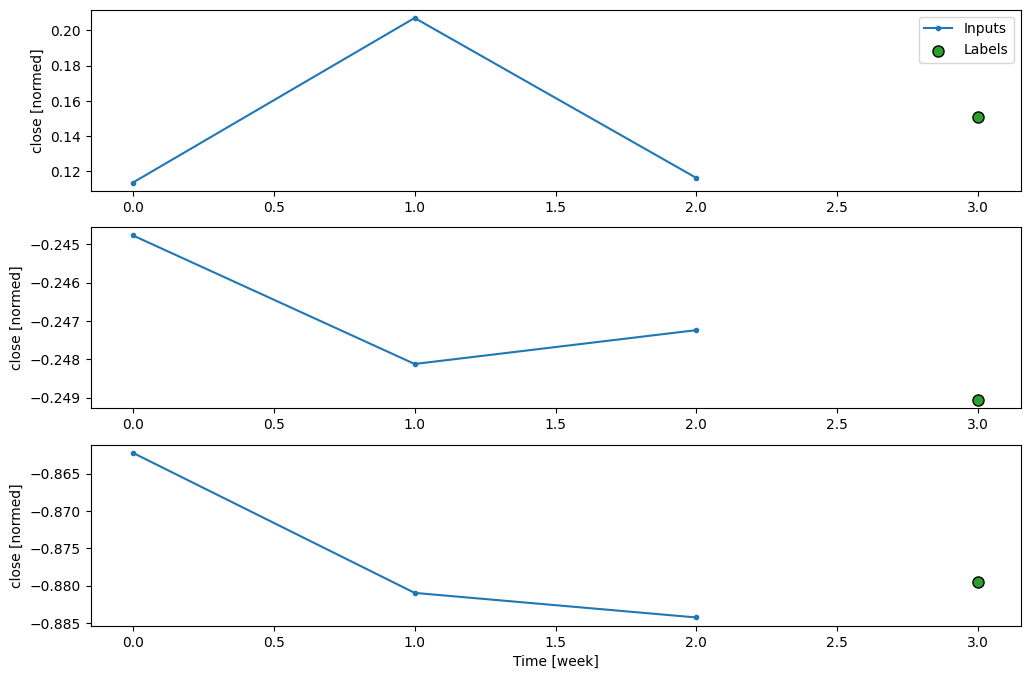

In [43]:
conv_window.plot()
#plt.suptitle("Given 3 weeks of inputs, predict 1 week into the future.")

In [44]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [45]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [46]:
history = cf.compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6647 - mean_absolute_error: 0.5375 - val_loss: 0.3710 - val_mean_absolute_error: 0.4216
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390 - mean_absolute_error: 0.1053 - val_loss: 0.6254 - val_mean_absolute_error: 0.5932
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - mean_absolute_error: 0.0746 - val_loss: 0.6648 - val_mean_absolute_error: 0.6106
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6761 - mean_absolute_error: 0.6096 


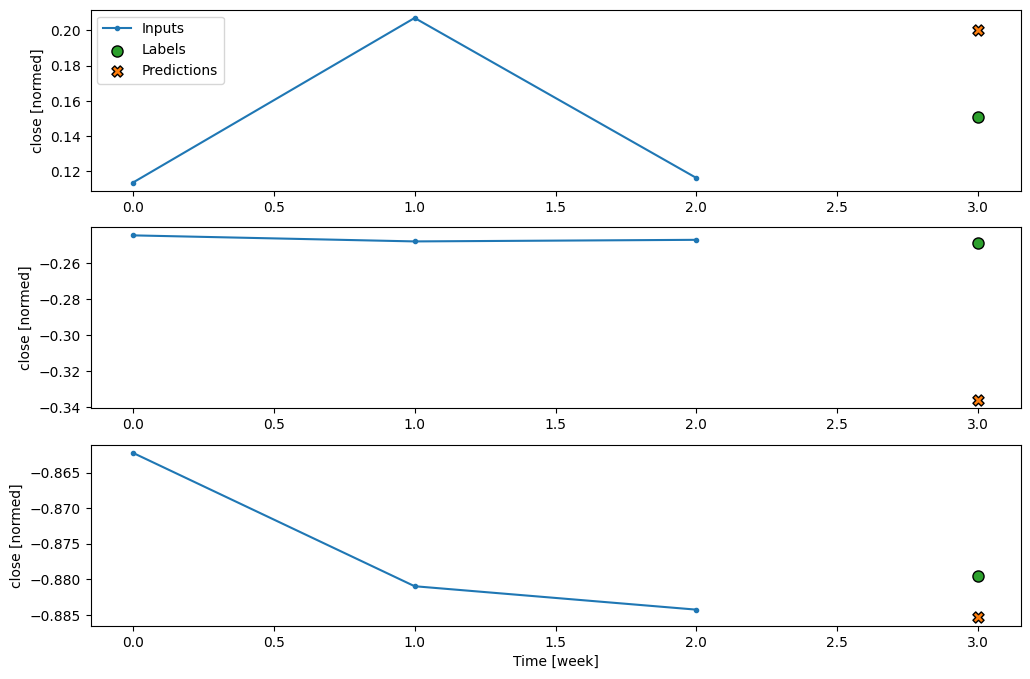

In [47]:
conv_window.plot(multi_step_dense)